<a href="https://colab.research.google.com/github/Shreya-07/CMPE258_project_foodcaloriedetection/blob/main/ProjectFoodcaloriedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image classification model using MobileNetV2.     

MobileNetV2 uses depthwise seperable convolution. It reduces the number of parameters when compared to the network with regular convolutions with the same depth in the nets. This model result in light weight deep neural network.   
 MobileNet is a class of CNN for open-sourced by google and this will be starting point for training our model classifier that are small and fast.   

 Depthwise sepearable convolution is a depthwise convoluttion followed by a pointwise convolution.   

Architecture - 
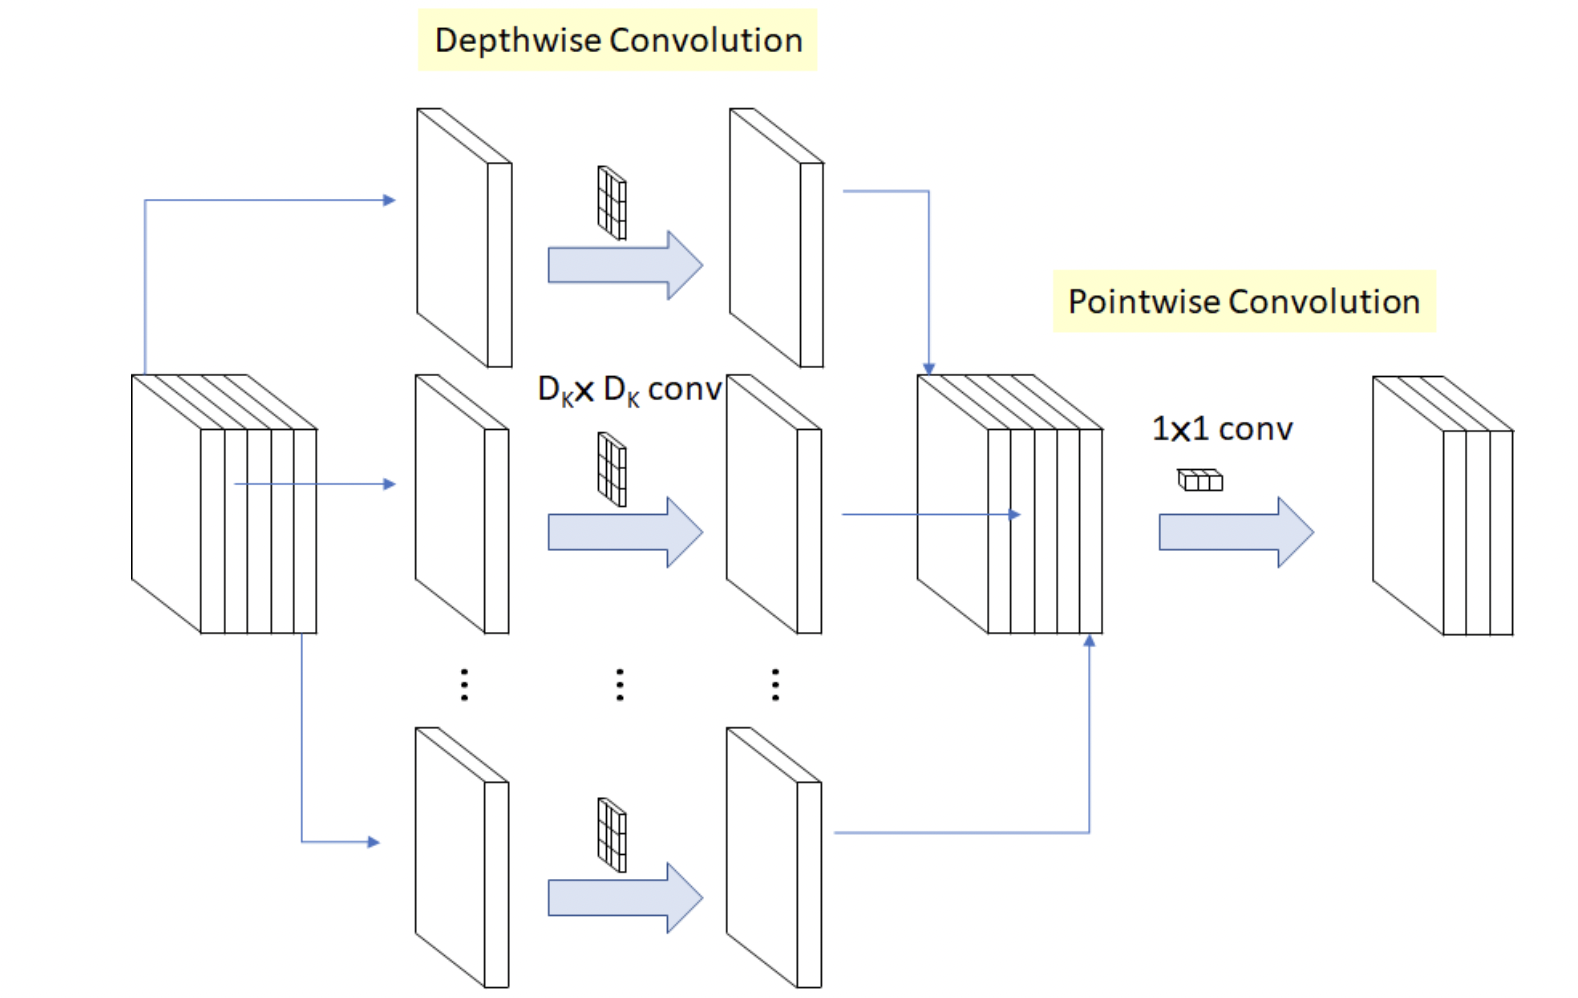

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_dir = Path('/content/drive/MyDrive/CMPE258Project_FoodCalorieDetection/evaluation/Train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('/content/drive/MyDrive/CMPE258Project_FoodCalorieDetection/evaluation/Test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('/content/drive/MyDrive/CMPE258Project_FoodCalorieDetection/evaluation/Validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))


In [6]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3143

Number of different labels: 11

Labels: ['Soup' 'Bread' 'Rice' 'Friedfood' 'Meat' 'Seafood' 'Dairyproduct'
 'VegetableFruit' 'NoodlesPasta' 'Dessert' 'Egg']


In [9]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/CMPE258Project_FoodCalo...,Soup
1,/content/drive/MyDrive/CMPE258Project_FoodCalo...,Bread
2,/content/drive/MyDrive/CMPE258Project_FoodCalo...,Bread
3,/content/drive/MyDrive/CMPE258Project_FoodCalo...,Soup
4,/content/drive/MyDrive/CMPE258Project_FoodCalo...,Rice


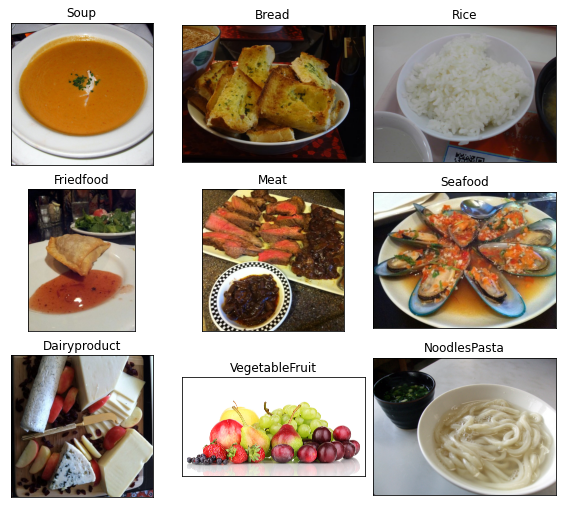

In [10]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3143 validated image filenames belonging to 11 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 135 validated image filenames belonging to 11 classes.


 Arguments passed to the model are.   
input shape which is the size of input,   
alpha which controls the width of the network is also known as width multiplier,   
depth multiplier for depth wise convolution is also called resolution multiplier,   
dropout is the dropout rate, include_top is the booleanwhere to include fully connected layer at the top of the network,   
weights used in this model is. 'imagenet',    
input tensor is the optional keras tensor useful for sharing inputs between multiple different networks,     
pooling is the layer used to reduce the dimentionality of feature map used 'average pooling' in the model,     
claases is the optional number of classes to classify images,      
classifier activation is str or callable function on the top layer used 'adm' optimizer. 

In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 135 validated image filenames belonging to 11 classes.


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 11,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
99/99 [==============================] - 638s 6s/step - loss: 0.9673 - accuracy: 0.6822 - val_loss: 0.8084 - val_accuracy: 0.7407
Epoch 2/200
99/99 [==============================] - 26s 261ms/step - loss: 0.4358 - accuracy: 0.8581 - val_loss: 0.6997 - val_accuracy: 0.8148
Epoch 3/200
99/99 [==============================] - 26s 258ms/step - loss: 0.2752 - accuracy: 0.9109 - val_loss: 0.8062 - val_accuracy: 0.7704
Epoch 4/200
99/99 [==============================] - 25s 256ms/step - loss: 0.1742 - accuracy: 0.9453 - val_loss: 0.7144 - val_accuracy: 0.7778


In [17]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]

In [18]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [19]:
model.save('FV1.h5')